# Haystacks processing

### Load file and dependencies

In [1]:
from astropy.io import fits
import numpy as np

# import plotting library & parameters
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

#################################################
# enable the following to use Times for the fonts
# plt.rc('font', family='serif', serif='Times')
# plt.rc('text', usetex=True)
#################################################
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rc('lines',linewidth=2)


Populating the interactive namespace from numpy and matplotlib


### This loads the file, but the data is not yet loaded

In [2]:
# you can work directly on the .fits.gz compressed file, although decompressing first can save some time
haystacks_file = '../modern_cube_zodi1inc0dist10_0.70-0.87um.fits'
haystacks = fits.open(haystacks_file)

### The image information is in the header of extension 0

In [3]:
cubehdr = haystacks[0].header
cubehdr

SIMPLE  =                    T / Written by IDL:  Tue Sep 19 21:25:35 2017      
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2017-09-20'         / Creation UTC (CCCC-MM-DD) date of FITS header  
SUN     =                    T / Sun in central pixel                           
LOCAL   =                    T / Local zodiacal background added                
COMMENT Spectral image cube of the Solar System.                                
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
BUNIT   = 'Jy      '           /Map units per pixel                             
INC     =              0.00000 /System inclination in degrees                   
ZODI    =              1.000

In [4]:
N_EXT = cubehdr['N_EXT']
print ("Number of extensions with data:",N_EXT)

('Number of extensions with data:', 64)


### The first extension with data is then extension 1

In [5]:
first_slice = haystacks[1].data
first_wavel = haystacks[1].header['WAVEL']
print ("Wavelength of first slice:", first_wavel," um")

('Wavelength of first slice:', 0.700566, ' um')


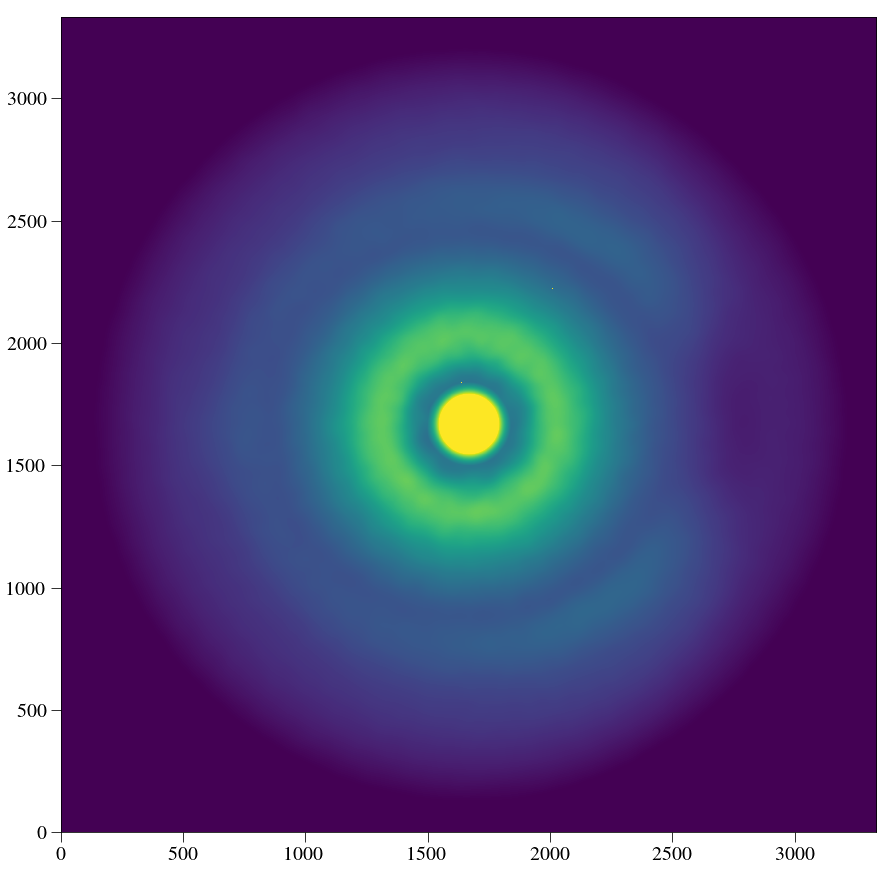

In [6]:
plt.figure(figsize=(15,15))
from matplotlib.colors import LogNorm
plt.imshow(first_slice,norm=LogNorm(vmin=2.2e-11,vmax=2.4e-11))

### The last slice is in extension N_EXT

In [7]:
last_slice = haystacks[N_EXT].data
last_wavel = haystacks[N_EXT].header['WAVEL']
print ("Wavelength of last slice:", last_wavel," um")

('Wavelength of last slice:', 0.865058, ' um')


### To assemble a single datacube in memory, just add the slices one by one

In [8]:
fullcube = np.zeros((N_EXT,first_slice.shape[0],first_slice.shape[1]),dtype=np.float32)
print (fullcube.shape)

(64, 3333, 3333)


In [9]:
# warning: this can take up a lot of memory! 
for i in range(N_EXT):
    fullcube[i] = haystacks[i+1].data

### Or use this function:

In [10]:
def haystacks_to_cube(fname):
    '''
    Function haystacks_to_cube
    
    This function reads a haystacks cube and returns a 3D ndarray with the data in Jy/pixel
    
    Parameters
    ----------
    fname: string
        Path to Haystacks filename
        
    Returns
    -------
    hc: ndarray
        Cube in Jy
    lamlist: wavelength array in um
            
    '''
    haystacks_hdu = fits.open(fname)
    
    # last extension is the list of wavelengths
    NEXT = haystacks_hdu[0].header['N_EXT']
    lamlist = haystacks_hdu[NEXT+1].data*u.um
    
    # allocate memory
    hc = np.zeros((NEXT,haystacks_hdu[1].data.shape[0],haystacks_hdu[1].data.shape[1]),dtype=np.float32)*u.Jy
    for i in range(NEXT):
        hc[i] = haystacks_hdu[i+1].data*u.Jy
        
    # convert to photon
    return hc,lamlist


### Wavelengths are in extension N_EXT+1


In [11]:
wavlist = haystacks[N_EXT+1].data
print (wavlist)

[ 0.70056552  0.7031765   0.70578748  0.70839846  0.71100944  0.71362042
  0.71623141  0.71884239  0.72145337  0.72406441  0.72667539  0.72928637
  0.73189735  0.73450834  0.73711932  0.7397303   0.74234128  0.74495226
  0.74756324  0.75017422  0.75278521  0.75539619  0.75800717  0.76061815
  0.76322913  0.76584017  0.76845109  0.77106214  0.77367312  0.7762841
  0.77889508  0.78150606  0.78411704  0.78672802  0.78933901  0.79194999
  0.79456097  0.79717195  0.79978293  0.80239391  0.80500489  0.80761588
  0.81022692  0.81283784  0.81544888  0.81805986  0.82067084  0.82328182
  0.82589281  0.82850379  0.83111477  0.83372575  0.83633673  0.83894771
  0.84155869  0.84416968  0.84678066  0.84939164  0.85200262  0.85461366
  0.85722458  0.85983562  0.86244661  0.86505759]


### Stellar flux is in extension N_EXT+2

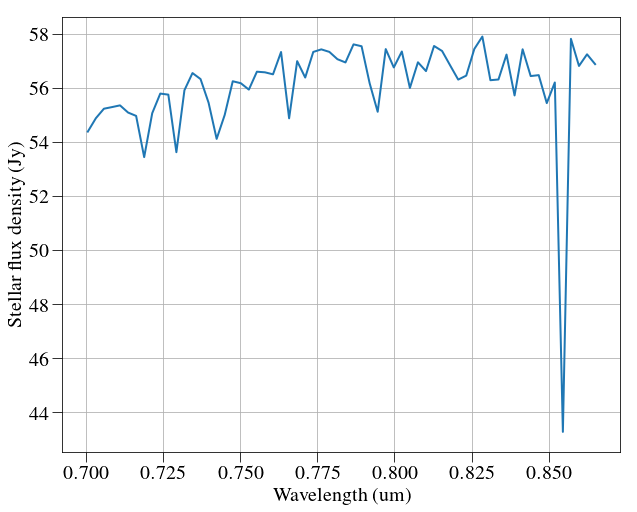

In [12]:
stellar = haystacks[N_EXT+2].data
plt.figure(figsize=(10,8))
plt.plot(wavlist,stellar)
plt.xlabel('Wavelength (um)')
plt.ylabel('Stellar flux density (Jy)')
plt.grid()

### Planet albedos are in extension N_EXT+3


('Number of planets is: ', 7)


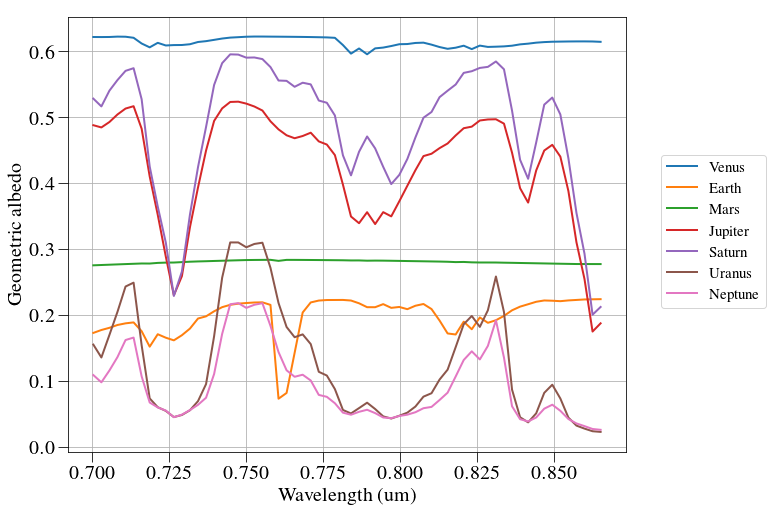

In [13]:
planetlist = ['Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']
planets = haystacks[N_EXT+3].data
print ("Number of planets is: ",planets.shape[0])
plt.figure(figsize=(10,8))
for p in range(planets.shape[0]):
    plt.plot(wavlist,planets[p],label=planetlist[p])
plt.xlabel('Wavelength (um)')
plt.ylabel('Geometric albedo')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 0.7))
plt.grid()

### Planet parameters are in extension N_EXT+4

In [14]:
params = haystacks[N_EXT+4].data
# lists of parameters for all planets
# parameters are normalized with GM = 4pi**2
radii = params[0,:] # planet radius in AU
a = params[1,:]     # semi major axis in AU
ecc = params[2,:]     # Eccentricity
inc = params[3,:]     # inclination (radians)
longperi = params[4,:]     # Longitude of perihelion (radians)
longnode = params[5,:]     # Longitude of ascending node (radians)
meanlong = params[6,:]     # Mean longitude (radians)
argperi = params[7,:]      # Argument of perihelion (radians) (=meanlong-longperi)
periods = params[8,:]      # Orbital periods (years) (=a**1.5, where a is in AU; 1AU -> 1 year)
meananom = params[9,:]     # Mean anomaly (radians) (=argperi+2*pi*epoch/periods)
X = params[10,:]     # X coordinate of planet (in AU in the 3D scene)
Y = params[11,:]     # Y coordinate of planet (in AU in the 3D scene)
Z = params[12,:]     # Z coordinate of planet (in AU in the 3D scene)
Xpix = params[13,:]     # X location in cube (second dimension in Python arrays)
Ypix = params[14,:]     # Y location in cube (first dimension in Python arrays)
print (Xpix,Ypix)


(array([ 1655.,  1699.,  1633.,  1635.,  1974.,  2007.,  2667.]), array([ 1687.,  1666.,  1626.,  1836.,  1571.,  2219.,  1666.]))


### Extract planet observed spectra

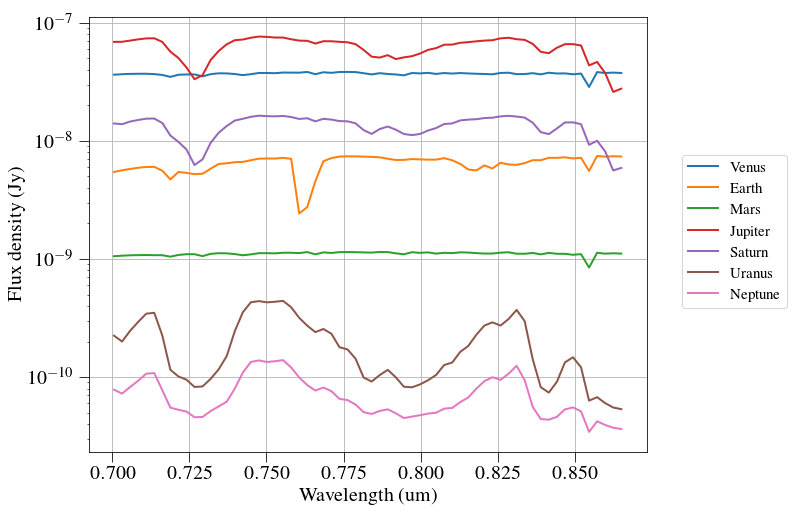

In [15]:
plt.figure(figsize=(10,8))
for p in range(planets.shape[0]):
    plt.semilogy(wavlist,fullcube[:,int(Ypix[p]),int(Xpix[p])],label=planetlist[p])
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux density (Jy)')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 0.70))
plt.grid()

## Look at a Haystacks cube at 60 degree inclination

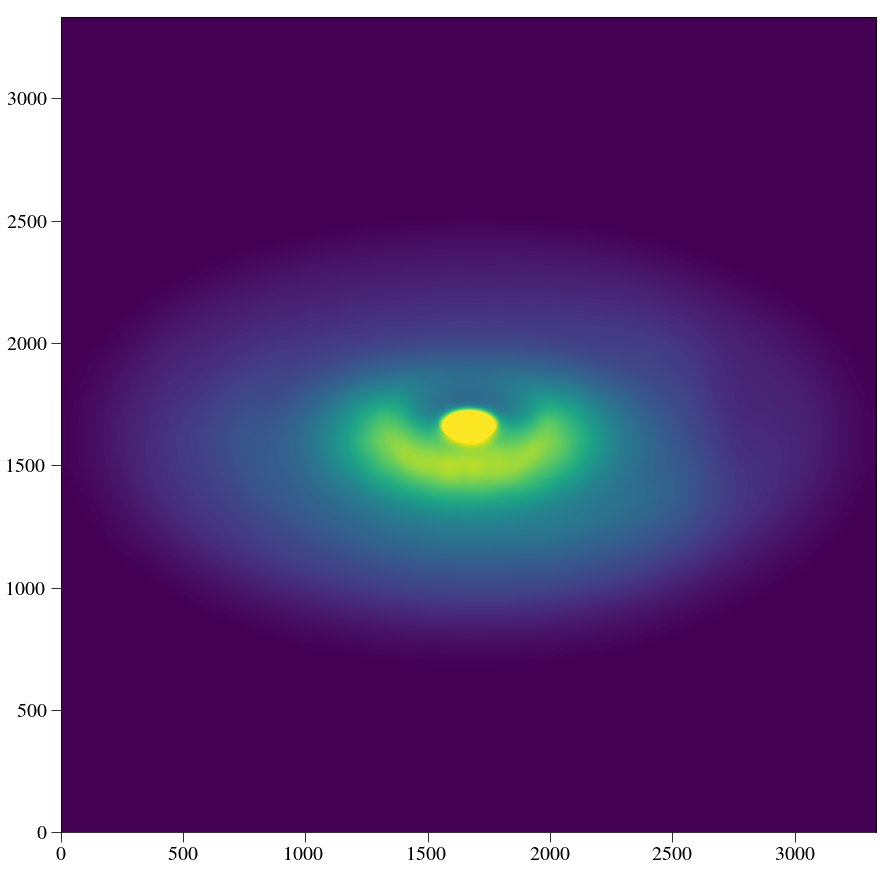

In [16]:
haystacks_file_inc60 = '../modern_cube_zodi1inc60dist10_0.70-0.87um.fits'
haystacks_inc60 = fits.open(haystacks_file_inc60)
first_slice_inc60 = haystacks_inc60[1].data
plt.figure(figsize=(15,15))
from matplotlib.colors import LogNorm
plt.imshow(first_slice_inc60,norm=LogNorm(vmin=2.2e-11,vmax=2.7e-11))

## Add background stars

In [17]:
# load the stellar cube
# the stellar cube has 3 dimensions:
# first axis matches the haystacks cube chunk
# second axis matches the number of extensions in the haystacks cube
# third axis corresponds to the number of stars in the system
background_stars = fits.open('../spectra.fits.gz')[0].data
print(background_stars.shape)

# use our existing cube at 0 degree inclination
# we are using the cube with index 4
shape = fullcube.shape
icube = 4
print(shape)
# create random positions
random_X = numpy.random.randint(0,shape[1],background_stars.shape[-1])
random_Y = numpy.random.randint(0,shape[2],background_stars.shape[-1])

# add the stars to all slices in this cube
fullcube[:,random_X,random_Y] += background_stars[icube,:,:]

(10, 64, 45)
(64, 3333, 3333)


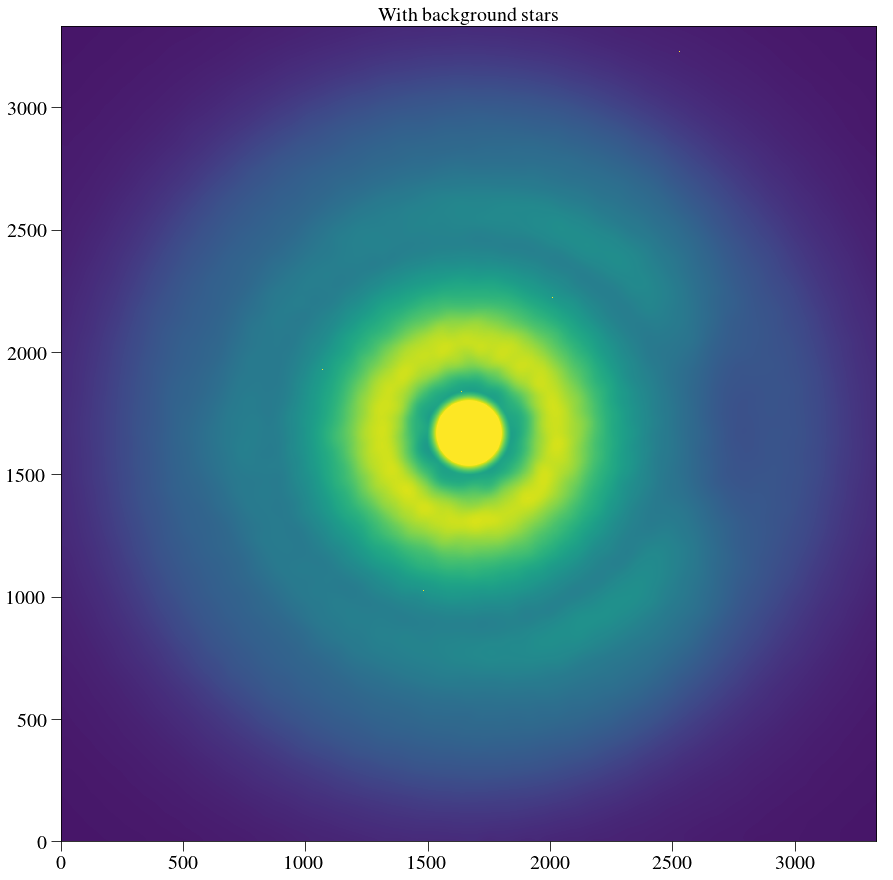

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(fullcube[-1],norm=LogNorm(vmin=2.2e-11,vmax=2.4e-11))
plt.title('With background stars',fontsize=20)

## Add background galaxies

The background galaxies have a larger FOV than the Haystacks cubes, but they also have a coarser pixel pitch. We will work towards resolving this issue in the future. In the meantime, if it necessary to obtain a 3mas pixel pitch (which is what haystacks cubes have), we need to interpolate the galaxy cubes by a factor of 3. 

In [19]:
from scipy.ndimage import map_coordinates as mapc

gal = fits.open('../GALAXIES_10lat0.70-0.87um.fits')
xregion = 1000
yregion = 1000
for i in range(shape[0]):
    # select a region from the galaxy cube
    gal_data = gal[1+i].data[xregion:xregion+shape[1]/3,yregion:yregion+shape[2]/3]
    
    # interpolate to higher resolution
    x = np.arange(shape[1])
    y = np.arange(shape[2])
    x,y = np.meshgrid(x,y)
    fullcube[i] += mapc(gal_data,[y/3.,x/3.],order=1)/9. # divide by the ratio of areas to ensure flux conservation


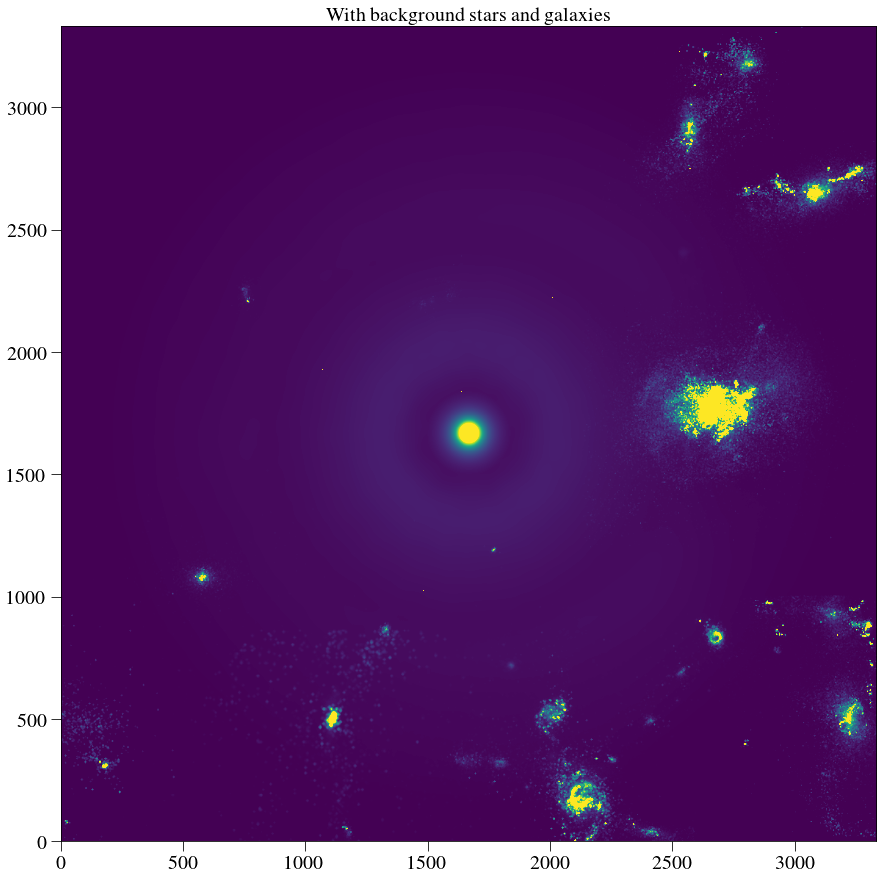

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(fullcube[0],norm=LogNorm(vmin=2.2e-11,vmax=5e-11))
plt.title('With background stars and galaxies',fontsize=20)

Note: the galaxy cubes are made of small "postage stamp" galaxies which have artificially straight edges. While this is on our to-do list for future improvements to our models, we note that these edges should not be visible in any realistic telescope construct, as they are extremely faint.

## Convert Haystacks cube to photons per second per area

In [21]:
import astropy.units as u
import astropy.constants as c

def Jy_to_photons(cube_Jy, wavel):
    '''
    Parameters
    ----------
        cube_Jy: 3D datacube in Jy
        wavel: 1D array with wavelengths in microns
    Returns
    -------
        hc: 3D haystacks cube in photons/m2/um/s
   
    '''
    lamlist = (wavel*u.um).to(u.nm)
    lamcube = c.c/lamlist[:,np.newaxis,np.newaxis]**2
    
    hc = cube_Jy * u.Jansky 
    
    hc = hc.to(u.Watt/u.m**2/u.Hertz)
    hc *= lamcube
    hc = hc.to(u.W/u.m**2/u.nm)
    
    # photon energy
    Eph = (c.h*c.c/lamlist[:,np.newaxis,np.newaxis]/u.photon).to(u.J/u.photon)
    hc = (hc/Eph).to(u.photon/u.s/u.m**2/u.um)
    
    return hc

In [22]:
haystacks_ph = Jy_to_photons(fullcube,wavlist)

In [23]:
print (haystacks_ph.unit)

ph / (m2 s um)


## Convert Haystacks cube to photons per second per slice for a given telescope

In [24]:
dlam = (wavlist[1]-wavlist[0])*u.um
telescope_area = np.pi*(9*u.m)**2/4.
Optical_Efficiency = 0.4 # this is more for a starshade-type observatory; a coronagraph will be much lower
Quantum_Efficiency = 0.85

haystacks_ph_per_slice = haystacks_ph*dlam*telescope_area*Optical_Efficiency*Quantum_Efficiency

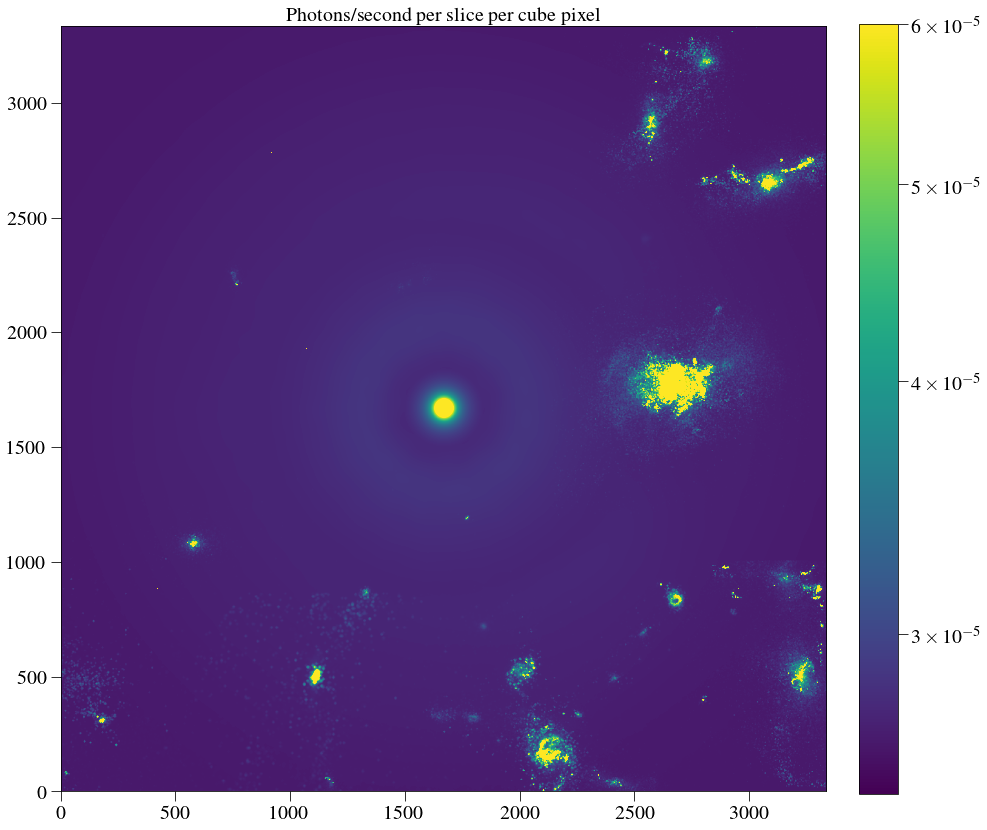

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(haystacks_ph_per_slice[0].value,norm=LogNorm(vmin=2.5e-5,vmax=6e-5))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Photons/second per slice per cube pixel',fontsize=20)

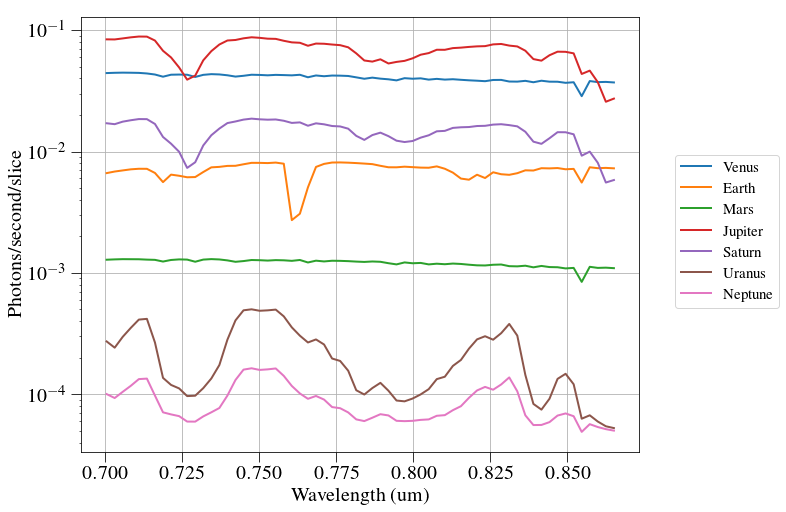

In [26]:
plt.figure(figsize=(10,8))
for p in range(planets.shape[0]):
    plt.semilogy(wavlist,haystacks_ph_per_slice[:,int(Ypix[p]),int(Xpix[p])],label=planetlist[p])
plt.xlabel('Wavelength (um)')
plt.ylabel('Photons/second/slice')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 0.70))
plt.grid()

## Directly from a Haystacks FITS file, convert to a 3D cube in photons

In [27]:
def haystacks_to_photons(fname):
    '''
    Function haystacks_to_photons
    
    This function converts a Haystacks file cube in Jy/pixels to a ndarray cube in photons/s/nm/m^2/pixel
    
    Parameters
    ----------
    cube: string
        Haystacks filename
        
    Returns
    -------
    hc: ndarray
        Converted cube in ph/s/um/m2
    lamlist: wavelength array
            
    '''
    haystacks_hdu = fits.open(fname)
    
    # last extension is the list of wavelengths
    NEXT = haystacks_hdu[0].header['N_EXT']
    lamlist = haystacks_hdu[NEXT+1].data*u.um
    lamcube = c.c/lamlist[:,np.newaxis,np.newaxis]**2
    
    # allocate memory
    hc = np.zeros((NEXT,haystacks_hdu[1].data.shape[0],haystacks_hdu[1].data.shape[1]),dtype=np.float32)*u.Jy
    for i in range(NEXT):
        hc[i] = haystacks_hdu[i+1].data*u.Jy
    
    # convert cube
    hc = hc.to(u.Watt/u.m**2/u.Hertz)
    hc *= lamcube
    hc = hc.to(u.W/u.m**2/u.um)
    
    # photon energy
    Eph = (c.h*c.c/lamlist[:,np.newaxis,np.newaxis]/u.photon).to(u.J/u.photon)
    
    # convert to photon
    return (hc/Eph).to(u.photon/u.s/u.m**2/u.nm),lamlist
